# Pivot review data in pandas

This notebook shows how data can be pivoted by python [pandas](https://pandas.pydata.org/) to reveal insights into the behaviour of reviewers. The use case and data is from Mark Harwood's talk on [entity-centric indexing](https://www.elastic.co/videos/entity-centric-indexing-mark-harwood).

An alternative version of this notebook uses the [Elastic data frames](https://www.elastic.co/guide/en/elastic-stack-overview/master/ml-dataframes.html) to create the same results.

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## Read data to pandas DataFrame

In [2]:
csv_handle = gzip.open('./anonreviews.csv.gz')

reviews = pd.read_csv(csv_handle)

reviews['date'] = pd.to_datetime(reviews['date'])

### Explore data

In [3]:
reviews.head()

,reviewerId,vendorId,rating,date
0,0,0,5,2006-04-07 17:08:00
1,1,1,5,2006-05-04 12:16:00
2,2,2,4,2006-04-21 12:26:00
3,3,3,5,2006-04-18 15:48:00
4,3,4,5,2006-04-18 15:49:00


In [4]:
reviews.describe()

,reviewerId,vendorId,rating
count,578805.000000,578805.000000,578805.000000
mean,174124.098437,60.645267,4.679671
std,116951.972209,54.488053,0.800891
min,0.000000,0.000000,0.000000
25%,70043.000000,20.000000,5.000000
50%,161052.000000,44.000000,5.000000
75%,272697.000000,83.000000,5.000000
max,400140.000000,246.000000,5.000000


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578805 entries, 0 to 578804
Data columns (total 4 columns):
reviewerId    578805 non-null int64
vendorId      578805 non-null int64
rating        578805 non-null int64
date          578805 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 17.7 MB


#### Distribution of reviews (high number of five star ratings)

In [ ]:
#align = {str} 'center'
#bottom = {ndarray} [0. 0. 0. 0. 0.]
#height = {ndarray} [5.30000e+02 1.18700e+04 1.03770e+04 1.49710e+04 5.41057e+05]
#kwargs = {dict} <class 'dict'>: {'log': False, 'color': '#1f77b4'}
#self = {AxesSubplot} AxesSubplot(0.125,0.125;0.775x0.755)
#width = {ndarray} [1. 1. 1. 1. 1.]
#x = {ndarray} [0.5 1.5 2.5 3.5 4.5] 
hist = reviews.hist(column="rating", bins = 5)

In [24]:
bins = [530.0, 11870.0, 10377.0, 14971.0, 541057.0]
objects = range(5)
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4]


<BarContainer object of 5 artists>

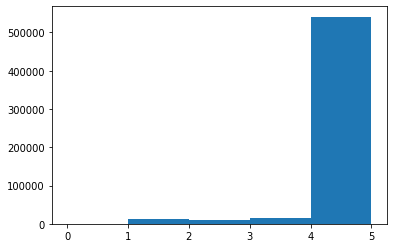

In [26]:
plt.bar(y_pos, bins, align='edge', width=1.0)

In [ ]:
#### Typically how many vendors does a reviewer review? (mainly one or two)

In [ ]:
plt.plot(reviews.groupby('reviewerId')['vendorId'].nunique(), '.')
plt.xlabel('reviewerId')
plt.ylabel('dc(vendorId)')
plt.show()

## Aggregate and Pivot data

Pivot data so we get summaries for each reviewer.

In [ ]:
aggregations = {
    'rating':'mean',
    'vendorId':'nunique',
    'reviewerId':'count'
}

grouped = reviews.groupby('reviewerId').agg(aggregations)
grouped.columns=['avg_rating', 'dc_vendorId', 'count']

In [ ]:
grouped.head()

In [ ]:
grouped.describe()

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

scatter_matrix(grouped)
plt.show()

### Find 'haters'

Reviewers that give more than five zero star reviews to one vendor

In [ ]:
grouped[ 
    (grouped['dc_vendorId'] == 1) & 
    (grouped['count'] > 5) & 
    (grouped['avg_rating'] == 0)
].sort_values('count', ascending=False)

For example, reviewer 10392 gives 94 zero star reviews to vendor 122

In [ ]:
reviews[reviews['reviewerId'] == 10392].head()

### Find 'fanboys'

Reviewers that give more than five five star reviews to one vendor

In [ ]:
grouped[ 
    (grouped['dc_vendorId'] == 1) & 
    (grouped['count'] > 5) & 
    (grouped['avg_rating'] == 5) 
].sort_values('count', ascending=False)

Reviewer 183751 gives 73 five star reviews to vendor 190

In [ ]:
reviews[reviews['reviewerId'] == 183751].head()